In [1]:
!pip install segmentation-models-pytorch albumentations scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 2.6 MB/s eta 0:00:0000:01


In [2]:
import glob
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import segmentation_models_pytorch as smp
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset


In [3]:
from torch import einsum, nn
from torch.nn.modules.loss import BCEWithLogitsLoss


def dice_round(preds, trues, t=0.5):
    preds = (preds > t).float()
    return 1 - soft_dice_loss(preds, trues, reduce=False)


def soft_dice_loss(outputs, targets, per_image=False, reduce=True):
    batch_size = outputs.size()[0]
    eps = 1e-5
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    union = torch.sum(dice_output, dim=1) + torch.sum(dice_target, dim=1) + eps
    loss = 1 - (2 * intersection + eps) / union
    if reduce:
        loss = loss.mean()

    return loss


def jaccard(outputs, targets, per_image=False, non_empty=False, min_pixels=5):
    batch_size = outputs.size()[0]
    eps = 1e-3
    if not per_image:
        batch_size = 1
    dice_target = targets.contiguous().view(batch_size, -1).float()
    dice_output = outputs.contiguous().view(batch_size, -1)
    target_sum = torch.sum(dice_target, dim=1)
    intersection = torch.sum(dice_output * dice_target, dim=1)
    losses = 1 - (intersection + eps) / (torch.sum(dice_output + dice_target, dim=1) - intersection + eps)
    if non_empty:
        assert per_image == True
        non_empty_images = 0
        sum_loss = 0
        for i in range(batch_size):
            if target_sum[i] > min_pixels:
                sum_loss += losses[i]
                non_empty_images += 1
        if non_empty_images == 0:
            return 0
        else:
            return sum_loss / non_empty_images

    return losses.mean()


class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False):
        super().__init__()
        self.size_average = size_average
        self.register_buffer("weight", weight)
        self.per_image = per_image

    def forward(self, input, target):
        return soft_dice_loss(input, target, per_image=self.per_image)


class JaccardLoss(nn.Module):
    def __init__(self, weight=None, size_average=True, per_image=False, non_empty=False, apply_sigmoid=False, min_pixels=5):
        super().__init__()
        self.size_average = size_average
        self.register_buffer("weight", weight)
        self.per_image = per_image
        self.non_empty = non_empty
        self.apply_sigmoid = apply_sigmoid
        self.min_pixels = min_pixels

    def forward(self, input, target):
        if self.apply_sigmoid:
            input = torch.sigmoid(input)
        return jaccard(input, target, per_image=self.per_image, non_empty=self.non_empty, min_pixels=self.min_pixels)


class StableBCELoss(nn.Module):
    def __init__(self):
        super(StableBCELoss, self).__init__()

    def forward(self, input, target):
        input = input.float().view(-1)
        target = target.float().view(-1)
        neg_abs = -input.abs()
        # todo check correctness
        loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
        return loss.mean()


class GeneralizedDice(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, probs, target):
        size = probs.size()
        pc = probs.type(torch.float32).view(size[0], 1, size[1], size[2])
        tc = target.type(torch.float32).view(size[0], 1, size[1], size[2])

        w = 1 / ((einsum("bcwh->bc", tc).type(torch.float32) + 1e-10) ** 2)
        intersection = w * einsum("bcwh,bcwh->bc", pc, tc)
        union = w * (einsum("bcwh->bc", pc) + einsum("bcwh->bc", tc))

        divided = 1 - 2 * (einsum("bc->b", intersection) + 1e-10) / (einsum("bc->b", union) + 1e-10)

        loss = divided.mean()

        return loss


class ComboLoss(nn.Module):
    def __init__(self, weights, per_image=False, skip_empty=True, channel_weights=[1, 0.1, 0.1], channel_losses=None):
        super().__init__()
        self.weights = weights
        self.bce = BCEWithLogitsLoss()
        self.dice = DiceLoss(per_image=per_image)
        self.gdl = GeneralizedDice()
        self.jaccard = JaccardLoss(per_image=per_image)
        self.focal = FocalLoss2d()
        self.mapping = {"bce": self.bce, "dice": self.dice, "gdl": self.gdl, "focal": self.focal, "jaccard": self.jaccard}
        self.expect_sigmoid = {"dice", "focal", "jaccard", "gdl"}
        self.per_channel = {"dice", "jaccard", "gdl"}
        self.values = {}
        self.channel_weights = channel_weights
        self.channel_losses = channel_losses
        self.skip_empty = skip_empty

    def forward(self, outputs, targets):
        loss = 0
        weights = self.weights
        sigmoid_input = torch.sigmoid(outputs)
        for k, v in weights.items():
            if not v:
                continue
            val = 0
            if k in self.per_channel:
                channels = targets.size(1)
                for c in range(channels):
                    if not self.channel_losses or k in self.channel_losses[c]:
                        if self.skip_empty and torch.sum(targets[:, c, ...]) < 50:
                            continue
                        val += self.channel_weights[c] * self.mapping[k](sigmoid_input[:, c, ...] if k in self.expect_sigmoid else outputs[:, c, ...], targets[:, c, ...])

            else:
                val = self.mapping[k](sigmoid_input if k in self.expect_sigmoid else outputs, targets)

            self.values[k] = val
            loss += self.weights[k] * val
        return loss


class FocalLoss2d(nn.Module):
    def __init__(self, gamma=1.5, ignore_index=255):
        super().__init__()
        self.gamma = gamma
        self.ignore_index = ignore_index

    def forward(self, outputs, targets):
        outputs = outputs.contiguous()
        targets = targets.contiguous()
        eps = 1e-8
        non_ignored = targets.view(-1) != self.ignore_index
        targets = targets.view(-1)[non_ignored].float()
        outputs = outputs.contiguous().view(-1)[non_ignored]
        outputs = torch.clamp(outputs, eps, 1.0 - eps)
        targets = torch.clamp(targets, eps, 1.0 - eps)
        pt = (1 - targets) * (1 - outputs) + targets * outputs
        return (-((1.0 - pt) ** self.gamma) * torch.log(pt)).mean()


In [4]:
device = "cuda"
BATCH_SIZE = 8

In [5]:
def plot_images_side_by_side(image1, image2, title1="", title2=""):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].imshow(image1)
    axs[0].set_title(title1)
    axs[0].axis("off")

    axs[1].imshow(image2)
    axs[1].set_title(title2)
    axs[1].axis("off")

    plt.show()


def dice_channels(prob, truth, threshold=0.5, eps=1e-9):
    num_imgs = prob.size(0)
    num_channels = prob.size(1)
    prob = (prob > threshold).float()
    truth = (truth > 0.5).float()
    prob = prob.view(num_imgs, num_channels, -1)
    truth = truth.view(num_imgs, num_channels, -1)
    intersection = prob * truth
    score = (2.0 * intersection.sum(2) + eps) / (prob.sum(2) + truth.sum(2) + eps)
    score[score >= 1] = 1
    return score.mean()


def train_epoch(loader, model, loss_function_seg, optimizer, device):
    model = model.to(device)
    model.train()
    avg_loss = 0.0
    optimizer.zero_grad()
    for image, mask in loader:
        x = image.to(device)
        y = mask.to(device)
        prediction_seg = model(x)
        loss = loss_function_seg(prediction_seg, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        avg_loss += loss.item()
    avg_loss /= len(loader)
    return avg_loss


def valid_epoch(loader, model, device):
    model = model.to(device)
    model.eval()
    scores = []
    with torch.no_grad():
        for image, mask in loader:
            x = image.to(device)
            y = mask.to(device)
            probs = torch.sigmoid(model(x))
            scores.append(dice_channels(probs, y))
    return torch.stack(scores).mean().item()

In [6]:
train_transforms = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5, border_mode=0),
        A.RandomBrightnessContrast(p=0.3),
        A.GaussianBlur(p=0.2),
        A.Resize(480, 480),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize(480, 480),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [7]:
class SegmentationDataset(Dataset):
    def __init__(self, img_paths, masks_paths, transforms):
        self.img_paths = img_paths
        self.masks_paths = masks_paths
        self.transforms = transforms

    def __getitem__(self, item):
        img_path = self.img_paths[item]
        mask_path = self.masks_paths[item]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = np.load(mask_path)

        transformed_data = self.transforms(image=img, mask=mask)
        img = transformed_data["image"]
        mask = transformed_data["mask"]

        return torch.from_numpy(img).permute(2, 0, 1), torch.from_numpy(mask).permute(2, 0, 1).float()

    def __len__(self):
        return len(self.img_paths)

In [8]:
img_path = sorted(glob.glob("/kaggle/input/datasets/shk1py/seg-data-aaa/data/train/images/*.jpg"))[0]
mask_path = sorted(glob.glob("/kaggle/input/datasets/shk1py/seg-data-aaa/data/train/masks/*.npy"))[0]
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = np.load(mask_path)

transformed_data = train_transforms(image=img, mask=mask)
transformed_img = transformed_data["image"]
transformed_mask = transformed_data["mask"]

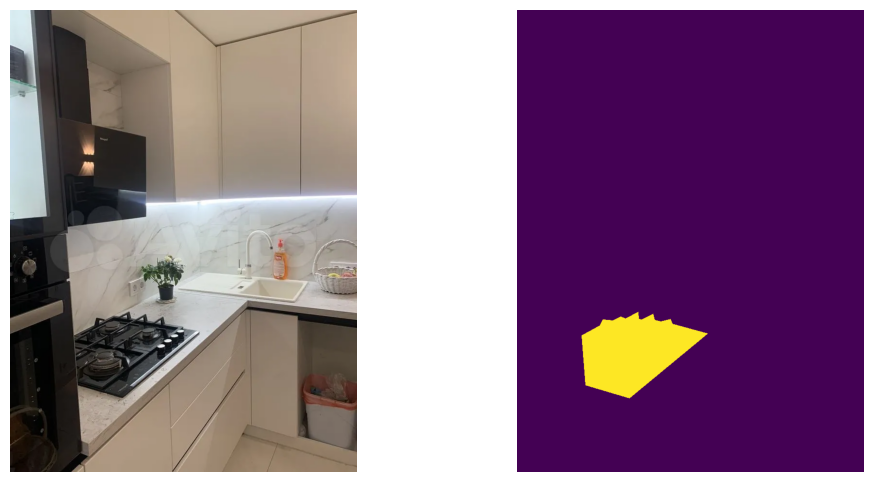

In [9]:
plot_images_side_by_side(img, mask[:, :, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.67058825..1.0].


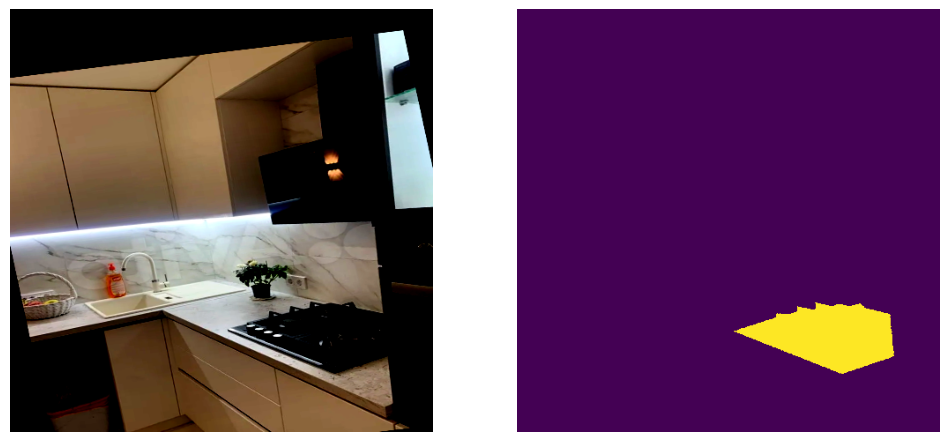

In [10]:
plot_images_side_by_side(transformed_img, transformed_mask[:, :, 0])

In [11]:
all_train_images = sorted(glob.glob("/kaggle/input/datasets/shk1py/seg-data-aaa/data/train/images/*.jpg"))
all_train_masks = sorted(glob.glob("/kaggle/input/datasets/shk1py/seg-data-aaa/data/train/masks/*.npy"))

train_images, valid_images, train_masks, valid_masks = train_test_split(all_train_images, all_train_masks, test_size=0.2, random_state=42)

all_test_images = sorted(glob.glob("/kaggle/input/datasets/shk1py/seg-data-aaa/data/test/images/*.jpg"))

len(train_images), len(train_masks), len(valid_images), len(valid_masks), len(all_test_images)

(96, 96, 24, 24, 37)

In [12]:
train_dataset = SegmentationDataset(train_images, train_masks, train_transforms)

valid_dataset = SegmentationDataset(valid_images, valid_masks, test_transforms)


train_loader = DataLoader(train_dataset, BATCH_SIZE, num_workers=4, shuffle=True)
valid_loader = DataLoader(valid_dataset, BATCH_SIZE, num_workers=4, shuffle=False)


print(len(train_dataset), len(valid_dataset))

96 24


In [13]:
sample = train_dataset[2]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


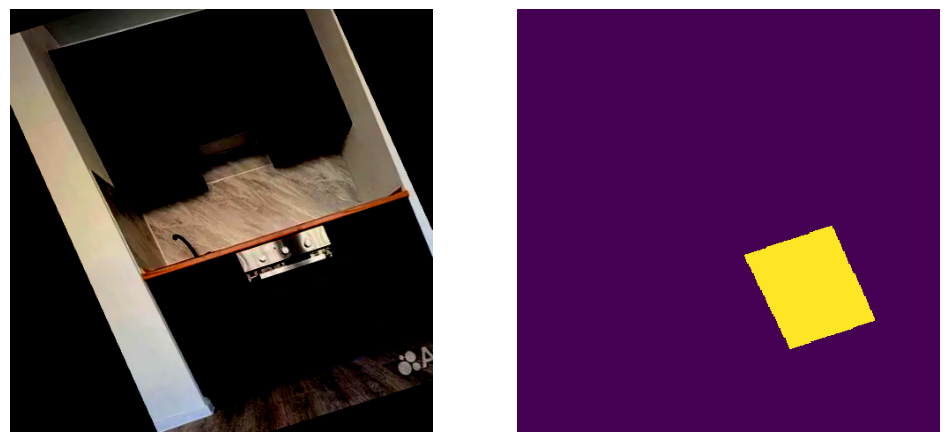

In [14]:
plot_images_side_by_side(sample[0].permute(1, 2, 0), sample[1].sum(0))

In [15]:
model = smp.Segformer(
    encoder_name="efficientnet-b5",
    encoder_weights='advprop',
    classes=4,
).to(device)

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

loss_fn = ComboLoss(weights={"focal": 0.25, "dice": 0.75}, channel_weights=[1] * 4)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)

config.json:   0%|          | 0.00/94.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/122M [00:00<?, ?B/s]

In [16]:
best_score = 0

for epoch in range(40):
    train_loss = train_epoch(train_loader, model, loss_fn, optimizer, device)
    valid_score = valid_epoch(valid_loader, model, device)

    scheduler.step(train_loss)
    if valid_score > best_score:
        torch.save(model.module.state_dict(), "best_model.pth")
        best_score = valid_score
    print(f"Epoch: {epoch}, train_loss: {train_loss:.4f}, valid_score: {valid_score:.3f}\n")

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:204: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0, train_loss: 2.9850, valid_score: 0.057

Epoch: 1, train_loss: 2.9018, valid_score: 0.085

Epoch: 2, train_loss: 2.7958, valid_score: 0.102

Epoch: 3, train_loss: 2.6319, valid_score: 0.153

Epoch: 4, train_loss: 2.5709, valid_score: 0.183

Epoch: 5, train_loss: 2.4897, valid_score: 0.232

Epoch: 6, train_loss: 2.4251, valid_score: 0.273

Epoch: 7, train_loss: 2.4152, valid_score: 0.305

Epoch: 8, train_loss: 2.3587, valid_score: 0.335

Epoch: 9, train_loss: 2.2637, valid_score: 0.320

Epoch: 10, train_loss: 2.2638, valid_score: 0.360

Epoch: 11, train_loss: 2.2344, valid_score: 0.370

Epoch: 12, train_loss: 2.1643, valid_score: 0.373

Epoch: 13, train_loss: 2.0077, valid_score: 0.459

Epoch: 14, train_loss: 1.9284, valid_score: 0.473

Epoch: 15, train_loss: 1.7765, valid_score: 0.522

Epoch: 16, train_loss: 1.6161, valid_score: 0.529

Epoch: 17, train_loss: 1.4800, valid_score: 0.519

Epoch: 18, train_loss: 1.3418, valid_score: 0.520

Epoch: 19, train_loss: 1.2483, valid_scor

In [17]:
model.module.load_state_dict(torch.load("best_model.pth"))

best_score = valid_epoch(valid_loader, model, device)
print(f"Best validation score: {best_score}")

Best validation score: 0.678661048412323


In [18]:
valid_image_path = sorted(valid_images)[7]

with torch.no_grad():
    img = cv2.imread(valid_image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    transformed_data = test_transforms(image=img)
    transformed_img = transformed_data["image"]
    model_input = torch.from_numpy(transformed_img).permute(2, 0, 1).unsqueeze(0)
    pred = model(model_input.to(device))
    mask = torch.sigmoid(pred).squeeze().cpu() > 0.5
    resized_mask = cv2.resize(mask.numpy().transpose((1, 2, 0)).astype(int), (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)

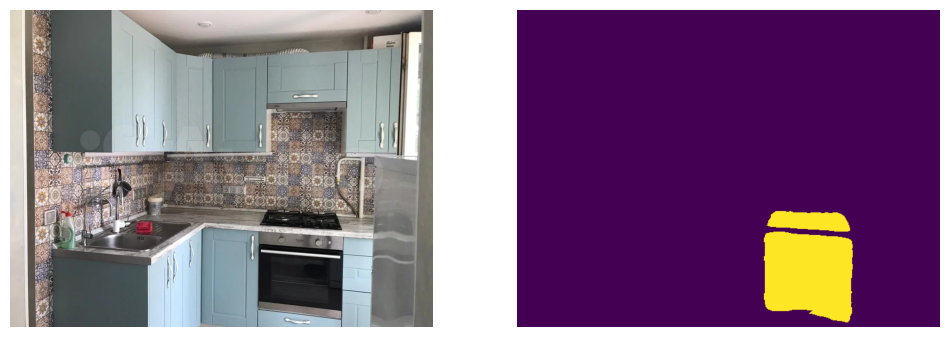

In [19]:
plot_images_side_by_side(img, resized_mask.sum(2, keepdims=True))

In [20]:
import os

import cv2
import numpy as np
import pandas as pd


def mask2rle(mask):
    '''
    mask: numpy array, 1 - pixel classified as target, 0 - background
    Returns run length as string formated
    '''
    rles = []
    for channel in range(mask.shape[2]):
        channel_mask = mask[:, :, channel]
        pixels = channel_mask.T.flatten()
        pixels = np.concatenate([[0], pixels, [0]])
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
        runs[1::2] -= runs[::2]
        rle_channel = ' '.join(str(x) for x in runs)
        rles.append(rle_channel)
    return ';'.join(rles)
 
def get_submission_df(img_paths, transforms, model, device='cuda'):
    '''
    img_paths: list of paths to test images
    transforms: albumentation test transforms
    model: the trained model
    Returns submission dataframe
    '''
    model = model.to(device)
    model.eval()
    submission_df = pd.DataFrame()
    c = 0
    with torch.no_grad():
        for n, img_path in enumerate(img_paths):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            transformed_data = transforms(image=img)
            transformed_img = transformed_data['image']
            model_input = torch.from_numpy(transformed_img).permute(2, 0, 1).unsqueeze(0)
            pred = model(model_input.to(device))
            mask = torch.sigmoid(pred).squeeze().cpu() > 0.5
            resized_mask = cv2.resize(
                mask.numpy().transpose((1, 2, 0)).astype(int),
                (img.shape[1], img.shape[0]),
                interpolation=cv2.INTER_NEAREST
            )
            submission_df.loc[c, 'image_id'] = os.path.basename(img_path)
            submission_df.loc[c, 'rle'] = mask2rle(resized_mask)
            submission_df.loc[c, 'batch_number'] = c
            c += 1
    return submission_df

In [21]:
submission_df = get_submission_df(all_test_images, test_transforms, model)
submission_df.to_csv(
    'solution.csv', 
    header=['image_id', 'rle', 'batch_number'], 
    index=False
)